# Início

In [3]:
import numpy as np
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.base import clone
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
import pickle
#from allfunc1 import *
from IPython.display import clear_output

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [16]:
df_pol = pd.read_csv("expd_apolar_molecules.CSV")
#df_pol = df_pol.drop(df_pol.loc[np.isnan(df_pol['axx (AA³)'])].index)
#df_pol.reset_index(drop=True, inplace = True)

In [17]:
df_pol = df_pol.drop([14,15,16,17,18,19,8,9])
df_pol

,Molecule,Formula,Ei,Alpha,Expt,DYS,SG,PauloPred,axx,ayy,azz,AlphaB,pi_bond
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.308,7.677,7.245,8.076667,0
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.725,9.393,8.743,9.953667,0
2,Hexane,C6H14,10.2,11.8,80,77.0,87.0,75.0,14.325,10.994,10.232,11.850333,0
3,Heptane,C7H16,9.9,13.7,105,100.0,117.0,105.0,16.910,12.658,11.715,13.761000,0
4,Octane,C8H18,10.0,15.5,115,123.0,144.0,119.0,19.595,14.255,13.193,15.681000,0
5,Nonane,C9H20,10.0,17.4,145,146.0,168.0,144.0,21.310,14.930,14.012,16.750667,0
6,Dodecane,C12H26,9.9,22.9,220,214.0,222.0,223.0,NaN,NaN,NaN,NaN,0
7,Hexadecane,C16H34,9.9,30.3,310,306.0,264.0,308.0,NaN,NaN,NaN,NaN,0
10,Cyclohexane,C6H12,9.9,11.8,80,68.0,NaN,83.0,11.290,11.290,9.778,10.786000,0
11,Benzene,C6H6,9.3,10.4,150,149.0,NaN,148.0,12.271,12.271,6.671,10.404333,3


Vou fazer o Dodecane e Hexadecane terem polarizabilidade anisotrópica igual a 1/3 de Alpha pra cada vetor.

In [18]:
for j in range(6,8):
    for i in range(8,11):
        df_pol.iloc[[j],[i]] = df_pol.iloc[[j],[3]]/3
df_pol

,Molecule,Formula,Ei,Alpha,Expt,DYS,SG,PauloPred,axx,ayy,azz,AlphaB,pi_bond
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.308000,7.677000,7.245000,8.076667,0
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.725000,9.393000,8.743000,9.953667,0
2,Hexane,C6H14,10.2,11.8,80,77.0,87.0,75.0,14.325000,10.994000,10.232000,11.850333,0
3,Heptane,C7H16,9.9,13.7,105,100.0,117.0,105.0,16.910000,12.658000,11.715000,13.761000,0
4,Octane,C8H18,10.0,15.5,115,123.0,144.0,119.0,19.595000,14.255000,13.193000,15.681000,0
5,Nonane,C9H20,10.0,17.4,145,146.0,168.0,144.0,21.310000,14.930000,14.012000,16.750667,0
6,Dodecane,C12H26,9.9,22.9,220,214.0,222.0,223.0,7.633333,7.633333,7.633333,NaN,0
7,Hexadecane,C16H34,9.9,30.3,310,306.0,264.0,308.0,10.100000,10.100000,10.100000,NaN,0
10,Cyclohexane,C6H12,9.9,11.8,80,68.0,NaN,83.0,11.290000,11.290000,9.778000,10.786000,0
11,Benzene,C6H6,9.3,10.4,150,149.0,NaN,148.0,12.271000,12.271000,6.671000,10.404333,3


In [21]:
x = df_pol[['Ei','Alpha']].values
x_pi = df_pol[['Ei','Alpha','pi_bond']].values

x_alpha = df_pol[['Ei','axx','ayy','azz']].values
x_alpha_pi = df_pol[['Ei','axx','ayy','azz', 'pi_bond']].values

#x_no_mol = df_pol[['Ei','Alpha']]
#x_no_mol = x_no_mol.drop([9]).values

y = df_pol[['Expt']].values

#y_no_mol = df_pol[['Expt']]
#y_no_mol = y_no_mol.drop([9]).values

x.shape, x_pi.shape, x_alpha.shape, x_alpha_pi.shape, y.shape,

((12, 2), (12, 3), (12, 4), (12, 5), (12, 1))

# Testa poli sem scaling

In [37]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('reg', linear_model.Ridge(max_iter=30000))])

space_poli1 = [

    Real(1e-5,100, 'log-uniform', name='reg__alpha'),
    Categorical([True, False], name = 'reg__fit_intercept'),
    Categorical([True, False], name = 'reg__copy_X'),
    Integer(1,10,name='poli__degree'),
    Categorical([True,False], name='poli__interaction_only'),
    Categorical([True,False], name = 'poli__include_bias')
]

In [38]:
test2 = gp_optimize(pipe_elastic, x, y, space_poli1, len(x))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0334
Function value obtained: 0.3901
Current minimum: 0.3901
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0255
Function value obtained: 0.3851
Current minimum: 0.3851
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0293
Function value obtained: 13.3679
Current minimum: 0.3851
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0277
Function value obtained: 0.3766
Current minimum: 0.3766
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0299
Function value obtained: 63.5743
Current minimum: 0.3766
Iteration No: 6 started. Evaluati

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.07624e-18): result may not be accurate.
  dual_coef = linalg.solve(

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0314
Function value obtained: 0.7127
Current minimum: 0.3735
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0305
Function value obtained: 0.3810
Current minimum: 0.3735
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0319
Function value obtained: 0.9638
Current minimum: 0.3735
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.0293
Function value obtained: 0.3761
Current minimum: 0.3735
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0281
Function value obtained: 0.3766
Current minimum: 0.3735
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.11e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.40572e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=9.24029e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.0335
Function value obtained: 189.5505
Current minimum: 0.3735
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.0354
Function value obtained: 189.5505
Current minimum: 0.3735
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.0290
Function value obtained: 0.3807
Current minimum: 0.3735
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.0264
Function value obtained: 0.3720
Current minimum: 0.3720
Iteration No: 19 started. Evaluating function at random point.
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.0263
Function value obtained: 500.8235
Current minimum: 0.3720
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 en

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.08637e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-sq

Iteration No: 23 ended. Evaluation done at random point.
Time taken: 0.0293
Function value obtained: 0.5166
Current minimum: 0.3720
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0267
Function value obtained: 0.3850
Current minimum: 0.3720
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.0251
Function value obtained: 1.9674
Current minimum: 0.3720
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 0.0271
Function value obtained: 0.4570
Current minimum: 0.3720
Iteration No: 27 started. Evaluating function at random point.
Iteration No: 27 ended. Evaluation done at random point.
Time taken: 0.0303
Function value obtained: 67.3010
Current minimum: 0.3720
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. 

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.79376e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.29051e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.49361e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.95236e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minic

Iteration No: 31 ended. Evaluation done at random point.
Time taken: 0.0246
Function value obtained: 67.3011
Current minimum: 0.3720
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 0.0310
Function value obtained: 3.5037
Current minimum: 0.3720
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 0.0299
Function value obtained: 0.3765
Current minimum: 0.3720
Iteration No: 34 started. Evaluating function at random point.
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 0.0262
Function value obtained: 0.3763
Current minimum: 0.3720
Iteration No: 35 started. Evaluating function at random point.
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 0.0268
Function value obtained: 0.4490
Current minimum: 0.3720
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. 

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.01656e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.40947e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.89725e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.6461e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minico

Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.0318
Function value obtained: 500.8235
Current minimum: 0.3720
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.0453
Function value obtained: 0.6376
Current minimum: 0.3720
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. Evaluation done at random point.
Time taken: 0.0265
Function value obtained: 0.4466
Current minimum: 0.3720
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 0.0289
Function value obtained: 0.4050
Current minimum: 0.3720
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.0285
Function value obtained: 0.3753
Current minimum: 0.3720
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended.

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.02434e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.32305e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.62283e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.42556e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minic

Iteration No: 54 ended. Evaluation done at random point.
Time taken: 0.0282
Function value obtained: 0.5164
Current minimum: 0.3720
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended. Evaluation done at random point.
Time taken: 0.0319
Function value obtained: 189.5507
Current minimum: 0.3720
Iteration No: 56 started. Evaluating function at random point.
Iteration No: 56 ended. Evaluation done at random point.
Time taken: 0.0295
Function value obtained: 0.3817
Current minimum: 0.3720
Iteration No: 57 started. Evaluating function at random point.
Iteration No: 57 ended. Evaluation done at random point.
Time taken: 0.0322
Function value obtained: 47.4949
Current minimum: 0.3720
Iteration No: 58 started. Evaluating function at random point.
Iteration No: 58 ended. Evaluation done at random point.
Time taken: 0.0283
Function value obtained: 0.4964
Current minimum: 0.3720
Iteration No: 59 started. Evaluating function at random point.
Iteration No: 59 ended

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.51062e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.08475e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.17216e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.90742e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minic

Iteration No: 61 ended. Evaluation done at random point.
Time taken: 0.0286
Function value obtained: 189.5507
Current minimum: 0.3720
Iteration No: 62 started. Evaluating function at random point.
Iteration No: 62 ended. Evaluation done at random point.
Time taken: 0.0276
Function value obtained: 0.4358
Current minimum: 0.3720
Iteration No: 63 started. Evaluating function at random point.
Iteration No: 63 ended. Evaluation done at random point.
Time taken: 0.0286
Function value obtained: 0.6250
Current minimum: 0.3720
Iteration No: 64 started. Evaluating function at random point.
Iteration No: 64 ended. Evaluation done at random point.
Time taken: 0.0309
Function value obtained: 0.3758
Current minimum: 0.3720
Iteration No: 65 started. Evaluating function at random point.
Iteration No: 65 ended. Evaluation done at random point.
Time taken: 0.0260
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 66 started. Evaluating function at random point.
Iteration No: 66 ended.

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.44136e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.63e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.17659e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.74372e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minicond

Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.0301
Function value obtained: 0.4406
Current minimum: 0.3720
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 0.0261
Function value obtained: 0.3868
Current minimum: 0.3720
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.0286
Function value obtained: 0.3750
Current minimum: 0.3720
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0295
Function value obtained: 0.3849
Current minimum: 0.3720
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.0304
Function value obtained: 0.9674
Current minimum: 0.3720
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. E

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.08532e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-sq

Iteration No: 76 ended. Evaluation done at random point.
Time taken: 0.0299
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 77 started. Evaluating function at random point.
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 0.0305
Function value obtained: 13.3688
Current minimum: 0.3720
Iteration No: 78 started. Evaluating function at random point.
Iteration No: 78 ended. Evaluation done at random point.
Time taken: 0.0301
Function value obtained: 3.6340
Current minimum: 0.3720
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 0.0308
Function value obtained: 0.3760
Current minimum: 0.3720
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 0.0310
Function value obtained: 0.3734
Current minimum: 0.3720
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. 

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home

Iteration No: 83 ended. Evaluation done at random point.
Time taken: 0.0304
Function value obtained: 0.3765
Current minimum: 0.3720
Iteration No: 84 started. Evaluating function at random point.
Iteration No: 84 ended. Evaluation done at random point.
Time taken: 0.0280
Function value obtained: 189.5507
Current minimum: 0.3720
Iteration No: 85 started. Evaluating function at random point.
Iteration No: 85 ended. Evaluation done at random point.
Time taken: 0.0273
Function value obtained: 189.5507
Current minimum: 0.3720
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 0.0273
Function value obtained: 0.3763
Current minimum: 0.3720
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 0.0267
Function value obtained: 0.5263
Current minimum: 0.3720
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ende

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.51062e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.08475e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.17216e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.90742e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minic

Iteration No: 91 ended. Evaluation done at random point.
Time taken: 0.0252
Function value obtained: 0.3734
Current minimum: 0.3720
Iteration No: 92 started. Evaluating function at random point.
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 0.0275
Function value obtained: 0.6241
Current minimum: 0.3720
Iteration No: 93 started. Evaluating function at random point.
Iteration No: 93 ended. Evaluation done at random point.
Time taken: 0.0252
Function value obtained: 0.5072
Current minimum: 0.3720
Iteration No: 94 started. Evaluating function at random point.
Iteration No: 94 ended. Evaluation done at random point.
Time taken: 0.0243
Function value obtained: 0.4684
Current minimum: 0.3720
Iteration No: 95 started. Evaluating function at random point.
Iteration No: 95 ended. Evaluation done at random point.
Time taken: 0.0246
Function value obtained: 13.3688
Current minimum: 0.3720
Iteration No: 96 started. Evaluating function at random point.
Iteration No: 96 ended. 

/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.25377e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.53649e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.3839e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.14743e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minico

Iteration No: 99 ended. Evaluation done at random point.
Time taken: 0.0262
Function value obtained: 0.3811
Current minimum: 0.3720
Iteration No: 100 started. Evaluating function at random point.
Iteration No: 100 ended. Evaluation done at random point.
Time taken: 1.9240
Function value obtained: 3.4072
Current minimum: 0.3720
Iteration No: 101 started. Searching for the next optimal point.
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 2.0195
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 102 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 1.8956
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 103 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 1.8316
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 1.7872
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 105 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 1.9564
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 1.8924
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 107 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 1.9607
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2844
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.0583
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 110 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 1.7998
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 111 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 1.8938
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 1.9825
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 113 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.47747e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.43622e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.77436e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.09104e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/mfasenra/minic

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.2252
Function value obtained: 0.9598
Current minimum: 0.3720
Iteration No: 114 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.2872
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 115 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.2863
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 116 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.1899
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 117 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.3606
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 118 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.1359
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 119 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.3686
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 120 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.3547
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 121 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.3918
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 122 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.3261
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 123 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.4891
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 124 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.2963
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 125 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.2885
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 126 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.1665
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.5164
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.4461
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 129 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.5160
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.4986
Function value obtained: 0.5113
Current minimum: 0.3720
Iteration No: 131 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.4293
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.2474
Function value obtained: 0.3765
Current minimum: 0.3720
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.5233
Function value obtained: 1.8907
Current minimum: 0.3720
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 2.7621
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.7300
Function value obtained: 0.3762
Current minimum: 0.3720
Iteration No: 136 st

/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.5046
Function value obtained: 0.6609
Current minimum: 0.3720
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.4968
Function value obtained: 0.3885
Current minimum: 0.3720
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 2.5975
Function value obtained: 0.4821
Current minimum: 0.3720
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 2.6905
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.5884
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 141 st

/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 2.8173
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.0699
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.1459
Function value obtained: 0.3851
Current minimum: 0.3720
Iteration No: 149 started. Searching for the next optimal point.


/home/mfasenra/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.2044
Function value obtained: 0.3766
Current minimum: 0.3720
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.4827
Function value obtained: 0.4962
Current minimum: 0.3720


In [39]:
att_model(pipe_elastic, space_poli1, test2.x)

In [40]:
metrics(pipe_elastic, x, y, len(x))

Informações sobre validação cruzada: 

Erros Relativos: [0.18249326 0.14534788 0.01803358 0.13247572 0.13644593 0.03050336
 0.00529565 0.06807742 1.19953103 2.4092299  0.23044944 0.32488573
 0.26749905 0.05790275]
Erro Relativo Médio: 0.37 /// Std of RE: 0.63/// Min and Max REE: 0.0052956528482595066, 2.4092299042327285

Erro Relativo do modelo sendo aplicado no data set inteiro: 0.2692952764660806



# Otimizando os 4 modelos.

In [27]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scaling', MinMaxScaler()),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scaling"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]

In [28]:
pipe = Pipeline([('scale',StandardScaler()),('reg',SVR())])
svr = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]

In [29]:
xgb = XGBRegressor(random_state=0)

space_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

In [30]:
pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 1500, random_state = 0, solver = 'adam'))])
nn = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    Real(0,1e-3, name='regressor__reg__alpha'),
    #Real(1e-6,1e-3,name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0,0.999,name = 'regressor__reg__beta_1'),
    Real(0,0.999,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]

In [31]:
estim=[svr,xgb,nn, ridge]
estim_names = ['svr','xgb','nn','poli']
spaces = [space_svr, space_xgb,space_nn, space_poli]


In [32]:
estim_list = opt_all(estim,estim_names,x,y,len(x),spaces )

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'scale', 8, 0.15082802737861578, 5.0, 0.01, StandardScaler(), StandardScaler()]
Cujo score de teste é: 0.3370134889921646

Para o estimador xgb, os parâmetros são: [0.11892012619029896, 822, 10, 2, 3.821899504285659, 0.342491429887267, 0.8853131127779329, 1.0, 0.0]
Cujo score de teste é: 0.37243080537837453

Para o estimador nn, os parâmetros são: ['relu', 0.0006070450611164517, 15, 10, 0.4555586085946495, 0.9055116689731112, 1.4584821589622268e-06, StandardScaler(), RobustScaler()]
Cujo score de teste é: 0.21550693522340578

Para o estimador poli, os parâmetros são: [1.5285803371283882e-05, True, False, 3, False, False, RobustScaler(), MinMaxScaler()]
Cujo score de teste é: 0.33135018775791575



In [52]:
metrics(estim_list[2],x,y,len(x), scoring="neg_mean_absolute_percentage_error")

Informações sobre validação cruzada: 

Erros Relativos: [0.05767837 0.03006829 0.04063156 0.05620129 0.07291277 0.05539813
 0.23387349 0.02867229 0.08429806 1.65542901 0.11416547 0.01553832
 0.30512215 0.2671079 ]
Erro Relativo Médio: 0.22 /// Std of RE: 0.41/// Min and Max REE: 0.01553832194539988, 1.6554290060532069

Erro Relativo do modelo sendo aplicado no data set inteiro: 0.07070925534439372



In [66]:
error_df = create_error_df(df_pol, estim_list, estim_names, x, y, len(x))

In [ ]:
pred_df = create_pred_df(df_pol, estim_list, estim_names, x, y)

# Usando ligações PI

In [9]:
scaler = ColumnTransformer([('scale', 
                              StandardScaler(),
                             [0,1]
                            )], remainder='passthrough')

In [10]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge_pi = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_pi_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]
poli_params = [0.0003279838662312496, False, False, 2, False, False, RobustScaler(), MinMaxScaler()]
att_model(ridge_pi,space_pi_poli,poli_params)

In [25]:
metrics(ridge_pi, x_pi,y,len(x))

Informações sobre validação cruzada: 

Erros Relativos: [0.02380526 0.04689233 0.00804197 0.04220698 0.09162887 0.01065128
 0.04605023 0.10070992 0.00632851 0.12736332 0.42379666 0.21105776]
Erro Relativo Médio: 0.09 /// Std of RE: 0.11/// Min and Max REE: 0.006328510882653049, 0.42379666347169914

Erro Relativo do modelo sendo aplicado no data set inteiro: 0.01581087637866167



0.0948777566839521

In [11]:
pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr_pi = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_pi_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]
svr_params = ['poly', 'auto', 7, 10.0, 0.1, 0.06307607208336928, MinMaxScaler(), RobustScaler()]
att_model(svr_pi,space_pi_svr,svr_params)

In [59]:
xgb_pi = XGBRegressor(random_state=0)

space_pi_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

In [60]:
pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 1500, random_state = 0, solver = 'adam'))])
nn_pi = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_pi_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    Real(0,1e-3, name='regressor__reg__alpha'),
    #Real(1e-6,1e-3,name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0,0.999,name = 'regressor__reg__beta_1'),
    Real(0,0.999,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]

In [61]:
estim_pi=[svr_pi,xgb_pi,nn_pi, ridge_pi]
estim_pi_names = ['svr_pi','xgb_pi','nn_pi','poli_pi']
spaces_pi = [space_pi_svr, space_pi_xgb,space_pi_nn, space_pi_poli]

In [62]:
estim_list_pi = opt_all(estim_pi,estim_pi_names,x_pi,y,len(x_pi),spaces_pi)

---------Polarizabilidade Isotrópica---------


Para o estimador svr_pi, os parâmetros são: ['poly', 'auto', 7, 10.0, 0.1, 0.06307607208336928, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.1225055002729776

Para o estimador xgb_pi, os parâmetros são: [0.07812284430905828, 1392, 4, 3, 4.2747166029007015, 0.4172501391599981, 1.0, 1.0, 0.31493277285809446]
Cujo score de teste é: 0.509993639193582

Para o estimador nn_pi, os parâmetros são: ['relu', 0.0009654162205199273, 12, 14, 0.5326730476627317, 0.23030249048282359, 4.00920600515727e-06, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.15965840436539414

Para o estimador poli_pi, os parâmetros são: [0.0003279838662312496, False, False, 2, False, False, RobustScaler(), MinMaxScaler()]
Cujo score de teste é: 0.05664728381696703



In [64]:
error_df_pi = create_error_df(df_pol, estim_list_pi, estim_pi_names, x_pi, y, len(x))
error_df_pi.sort_values(by='nn_pi',ascending=False)

,Molecule,Formula,Ei (meV),Alpha (AA³),Expt (meV),DYS,SG,PauloPred,axx (AA³),ayy (AA³),azz (AA³),AlphaB (AA³),pi_bond,svr_pi,xgb_pi,nn_pi,poli_pi
8,Ethylene,C2H4,10.5,4.2,20,-17.0,NaN,20.0,5.429,3.766,3.346,4.180333,1,0.204801,0.087251,0.598110,0.087218
13,2-3-butanedione,C4H6O2,9.3,8.2,77,92.0,NaN,79.0,9.758,9.073,6.117,8.316000,2,0.180799,0.382067,0.315544,0.226175
9,Cyclopropane,C3H6,9.9,5.7,10,1.0,NaN,10.0,5.750,5.750,5.035,5.511667,0,0.361674,3.109308,0.265378,0.114334
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.725,9.393,8.743,9.953667,0,0.059660,0.355207,0.200023,0.061010
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.308,7.677,7.245,8.076667,0,0.210104,0.950836,0.194214,0.052548
12,Naphthalene,C10H8,8.2,16.6,300,296.0,NaN,301.0,25.712,18.700,9.826,18.079333,5,0.243806,0.080846,0.158605,0.016775
7,Hexadecane,C16H34,9.9,30.3,310,306.0,264.0,308.0,NaN,NaN,NaN,NaN,0,0.037229,0.299231,0.126608,0.046029
4,Octane,C8H18,10.0,15.5,115,123.0,144.0,119.0,19.595,14.255,13.193,15.681000,0,0.101338,0.139012,0.095821,0.086489
3,Heptane,C7H16,9.9,13.7,105,100.0,117.0,105.0,16.910,12.658,11.715,13.761000,0,0.062821,0.460035,0.089684,0.036831
10,Cyclohexane,C6H12,9.9,11.8,80,68.0,NaN,83.0,11.290,11.290,9.778,10.786000,0,0.036524,0.285638,0.073648,0.003247


In [132]:
estim_list_pi[3].get_params

<bound method BaseEstimator.get_params of TransformedTargetRegressor(regressor=Pipeline(steps=[('poli',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('scale',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale',
                                                                                       RobustScaler(),
                                                                                       [0,
                                                                                        1])])),
                                                     ('reg',
                                                      Ridge(alpha=0.0003279838662312496,
                                                            copy_X=False,
                               

In [183]:
poli_reg = estim_list_pi[3]

In [182]:
# Monomios do polinomio
blabla = poli_reg.regressor.fit(x_pi,y)
blabla[0].get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [178]:
#Respectivos coeficientes
blablabla.coef_

array([[-6.16927051e+00,  1.16701730e+02, -1.55554413e+00,
         1.30188469e+00, -4.62161121e-01,  3.22988259e+00,
         4.47570593e-02, -7.73562413e+00,  2.66209756e+01]])

In [70]:
pred_df_pi = create_pred_df(df_pol, estim_list, estim_names, x_pi, y)
np.round(pred_df_pi,2)

,Molecule,Formula,Ei (meV),Alpha (AA³),Expt (meV),DYS,SG,PauloPred,axx (AA³),ayy (AA³),azz (AA³),AlphaB (AA³),pi_bond,svr,xgb,nn,poli
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.31,7.68,7.24,8.08,0,35.90,35.490002,36.09,36.20
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.72,9.39,8.74,9.95,0,55.84,62.689999,62.91,57.82
2,Hexane,C6H14,10.2,11.8,80,77.0,87.0,75.0,14.32,10.99,10.23,11.85,0,79.23,77.379997,83.00,79.12
3,Heptane,C7H16,9.9,13.7,105,100.0,117.0,105.0,16.91,12.66,11.72,13.76,0,104.05,109.110001,101.82,102.69
4,Octane,C8H18,10.0,15.5,115,123.0,144.0,119.0,19.60,14.26,13.19,15.68,0,123.60,109.889999,121.08,122.00
5,Nonane,C9H20,10.0,17.4,145,146.0,168.0,144.0,21.31,14.93,14.01,16.75,0,144.48,149.029999,147.48,143.11
6,Dodecane,C12H26,9.9,22.9,220,214.0,222.0,223.0,NaN,NaN,NaN,NaN,0,219.11,271.649994,222.78,218.79
7,Hexadecane,C16H34,9.9,30.3,310,306.0,264.0,308.0,NaN,NaN,NaN,NaN,0,309.07,271.649994,305.22,310.29
8,Ethylene,C2H4,10.5,4.2,20,-17.0,NaN,20.0,5.43,3.77,3.35,4.18,1,20.96,22.920000,17.67,20.00
9,Cyclopropane,C3H6,9.9,5.7,10,1.0,NaN,10.0,5.75,5.75,5.04,5.51,0,10.91,13.640000,19.22,10.37


# Visualização Gráfica Pi vs No Pi

In [67]:
df_graph = error_df.merge(error_df_pi, how='left')
df_graph

,Molecule,Formula,Ei (meV),Alpha (AA³),Expt (meV),DYS,SG,PauloPred,axx (AA³),ayy (AA³),...,AlphaB (AA³),pi_bond,svr,xgb,nn,poli,svr_pi,xgb_pi,nn_pi,poli_pi
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.308,7.677,...,8.076667,0,0.392790,0.351860,0.057678,0.752087,0.210104,0.950836,0.194214,0.052548
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.725,9.393,...,9.953667,0,0.065729,0.619161,0.030068,0.286090,0.059660,0.355207,0.200023,0.061010
2,Hexane,C6H14,10.2,11.8,80,77.0,87.0,75.0,14.325,10.994,...,11.850333,0,0.004002,0.290948,0.040632,0.182461,0.049701,0.152029,0.015361,0.020499
3,Heptane,C7H16,9.9,13.7,105,100.0,117.0,105.0,16.910,12.658,...,13.761000,0,0.006569,0.557322,0.056201,0.087100,0.062821,0.460035,0.089684,0.036831
4,Octane,C8H18,10.0,15.5,115,123.0,144.0,119.0,19.595,14.255,...,15.681000,0,0.079034,0.063613,0.072913,0.103974,0.101338,0.139012,0.095821,0.086489
5,Nonane,C9H20,10.0,17.4,145,146.0,168.0,144.0,21.310,14.930,...,16.750667,0,0.078560,0.344364,0.055398,0.018940,0.006654,0.189414,0.063447,0.008852
6,Dodecane,C12H26,9.9,22.9,220,214.0,222.0,223.0,NaN,NaN,...,NaN,0,0.069129,0.253282,0.233873,0.100259,0.050878,0.245313,0.027999,0.033015
7,Hexadecane,C16H34,9.9,30.3,310,306.0,264.0,308.0,NaN,NaN,...,NaN,0,0.425104,0.312711,0.028672,0.354113,0.037229,0.299231,0.126608,0.046029
8,Ethylene,C2H4,10.5,4.2,20,-17.0,NaN,20.0,5.429,3.766,...,4.180333,1,0.034775,0.055642,0.084298,0.707811,0.204801,0.087251,0.598110,0.087218
9,Cyclopropane,C3H6,9.9,5.7,10,1.0,NaN,10.0,5.750,5.750,...,5.511667,0,1.986424,1.238959,1.655429,0.005320,0.361674,3.109308,0.265378,0.114334


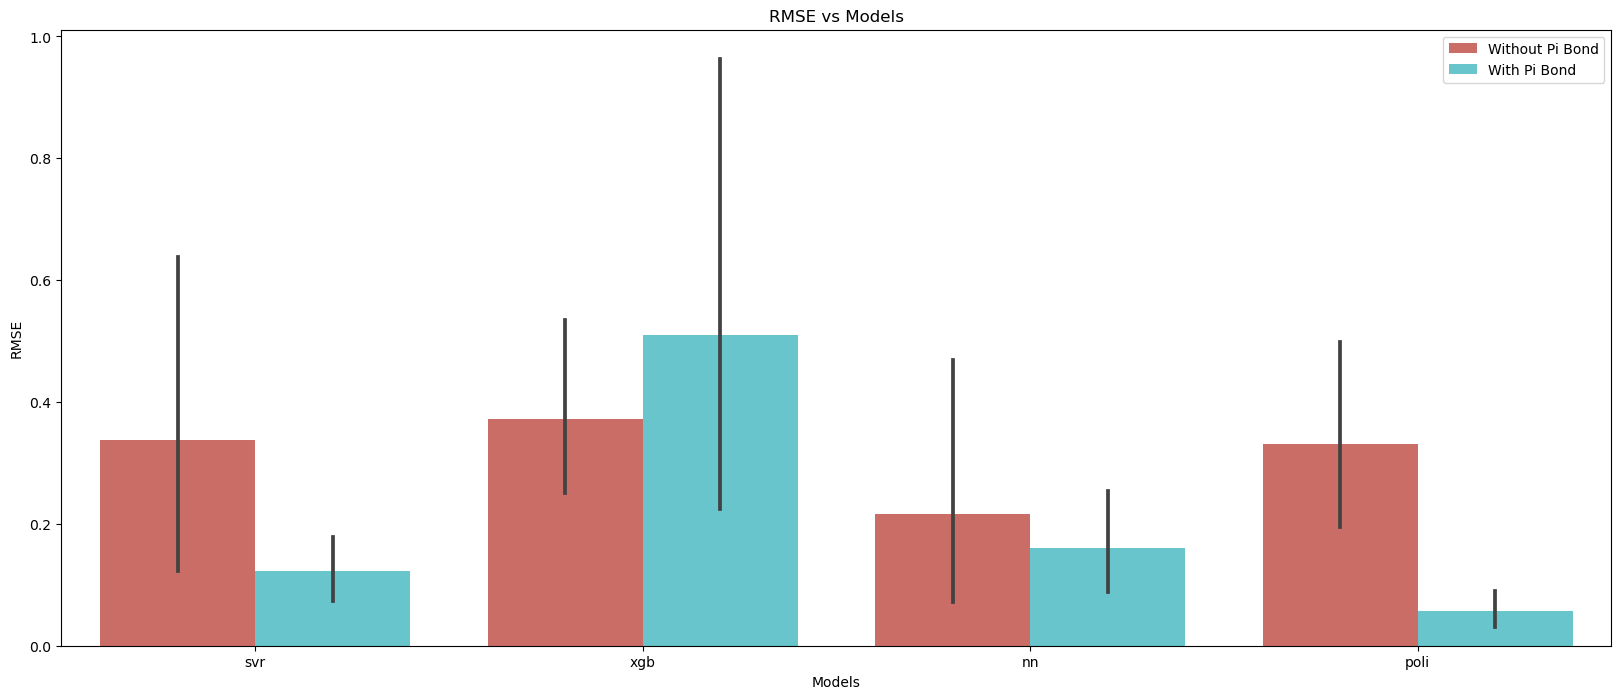

In [68]:
get_estim_dist(df_graph, aux_model=['svr','xgb','nn','poli'], hue=['Without Pi Bond', 'With Pi Bond'])

# Aniso sem PI Bond

In [81]:
estim_aniso = opt_all(estim, estim_names, x_alpha, y, len(x_alpha), spaces, iso_polarizability=False)

---------Polarizabilidade Anisotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'auto', 2, 4.919442750658442, 1.575058008584187, 0.01, MinMaxScaler(), StandardScaler()]
Cujo score de teste é: 0.4572060830158677

Para o estimador xgb, os parâmetros são: [0.00039769079307668583, 1268, 15, 4, 6.0, 1.0, 0.10247771483910127, 0.0, 1.0]
Cujo score de teste é: 0.6354625989350486

Para o estimador nn, os parâmetros são: ['relu', 0.00042429284577265894, 11, 17, 0.6205868550305054, 0.23994382996542485, 8.50873234009392e-06, StandardScaler(), StandardScaler()]
Cujo score de teste é: 0.46619469862164226

Para o estimador poli, os parâmetros são: [100.0, False, False, 8, False, True, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5934030630405738



In [82]:
estim_names_aniso = ['svr_aniso','xgb_aniso','nn_aniso','poli_aniso']

In [83]:
error_aniso_df = create_error_df(df_pol, estim_aniso, estim_names_aniso, x_alpha, y , len(x_alpha))
error_aniso_df.head(2)

,Molecule,Formula,Ei (meV),Alpha (AA³),Expt (meV),DYS,SG,PauloPred,axx (AA³),ayy (AA³),azz (AA³),AlphaB (AA³),pi_bond,svr_aniso,xgb_aniso,nn_aniso,poli_aniso
0,Butane,C4H10,10.6,8.1,35,31.0,26.0,39.0,9.308,7.677,7.245,8.076667,0,0.184100,0.030214,0.014789,0.659115
1,Pentane,C5H12,10.4,10.0,60,54.0,56.0,54.0,11.725,9.393,8.743,9.953667,0,0.012522,0.203387,0.246652,0.167150


# Aniso com PI Bond

In [84]:
estim_aniso_pi = opt_all(estim_pi, estim_pi_names, x_alpha_pi, y, len(x_alpha), spaces_pi, iso_polarizability=False)

---------Polarizabilidade Anisotrópica---------


Para o estimador svr_pi, os parâmetros são: ['rbf', 'scale', 2, 7.907371231400974, 1.8983645754000862, 0.019119938576296593, MinMaxScaler(), StandardScaler()]
Cujo score de teste é: 0.32411016039777074

Para o estimador xgb_pi, os parâmetros são: [0.00045356616894897425, 969, 13, 3, 3.2109858367434225, 0.9859920735317519, 0.4287248524000856, 1.0, 0.5631144878695068]
Cujo score de teste é: 0.6688472578767978

Para o estimador nn_pi, os parâmetros são: ['relu', 0.00095185036259304, 9, 15, 0.8049411410791506, 0.999, 7.497176215592992e-07, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.27404245702735835

Para o estimador poli_pi, os parâmetros são: [0.07657750353124913, True, False, 1, False, False, RobustScaler(), MinMaxScaler()]
Cujo score de teste é: 0.582783778566157



In [86]:
estim_names_anisopi = ['svr_aniso_pi','xgb_aniso_pi','nn_aniso_pi','poli_aniso_pi']

In [87]:
error_aniso_pi_df = create_error_df(df_pol, estim_aniso_pi, estim_names_anisopi, x_alpha_pi, y , len(x_alpha))

# Gráficos All

In [88]:
df_graph_all = error_df.merge(error_aniso_df, how='left')
df_graph_all = df_graph_all.merge(error_df_pi, how='left')
df_graph_all = df_graph_all.merge(error_aniso_pi_df, how='left')

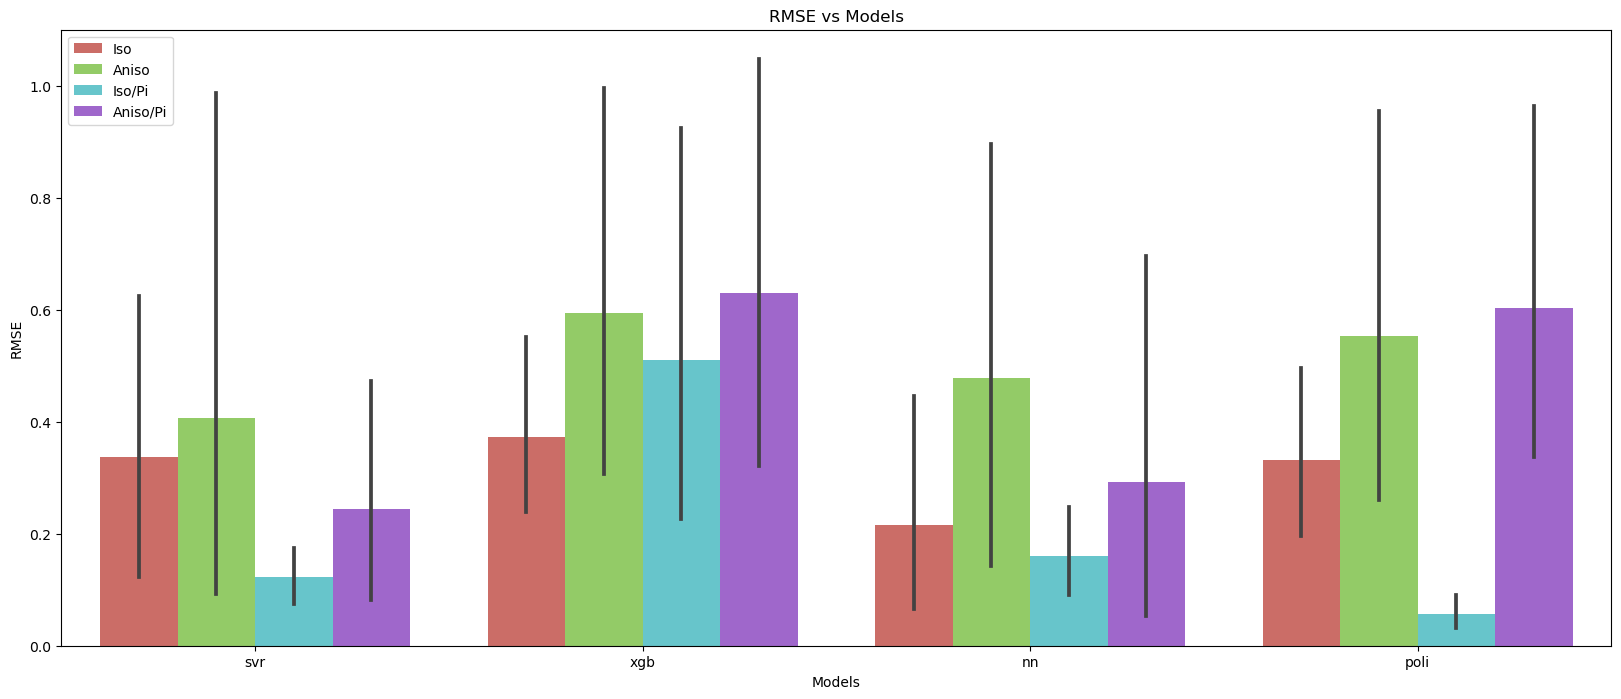

In [90]:
get_estim_dist(df_graph_all, aux_model=['svr','xgb','nn','poli'], hue=['Iso', 'Aniso','Iso/Pi','Aniso/Pi'])

# Sem molécula de 10 meV

In [121]:
estim_pi=[svr_pi,xgb_pi,nn_pi, ridge_pi]
estim_pi_names = ['svr_pi_nomol','xgb_pi_nomol','nn_pi_nomol','poli_pi_nomol']
spaces_pi = [space_pi_svr, space_pi_xgb,space_pi_nn, space_pi_poli]

In [115]:
estim_no_mol = opt_all(estim_pi,estim_pi_names,x_no_mol,y_no_mol,len(x_no_mol),spaces_pi)

---------Polarizabilidade Isotrópica---------


Para o estimador svr_pi, os parâmetros são: ['rbf', 'auto', 1, 0.0, 5.0, 0.01, MinMaxScaler(), StandardScaler()]
Cujo score de teste é: 0.18340667471390934

Para o estimador xgb_pi, os parâmetros são: [0.0015716773475155667, 847, 14, 1, 0.0, 0.9637592553853427, 0.9969678605080151, 1.0, 0.6538680755787855]
Cujo score de teste é: 0.30069769423965664

Para o estimador nn_pi, os parâmetros são: ['relu', 0.0007551061787832723, 2, 10, 0.8239729079090324, 0.6679372419381274, 5.504584205032256e-06, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.11920356425560077

Para o estimador poli_pi, os parâmetros são: [0.0003279838662312496, False, False, 2, False, False, RobustScaler(), MinMaxScaler()]
Cujo score de teste é: 0.15897358741775108



In [122]:
error_no_mol = create_error_df(df_pol.drop([9]), estim_no_mol, estim_pi_names, x_no_mol, y_no_mol, len(x_no_mol))

## Gráfico antes e depois da retirada de molécula

In [123]:
df_graph_nomol = error_df_pi.merge(error_no_mol, how='left')

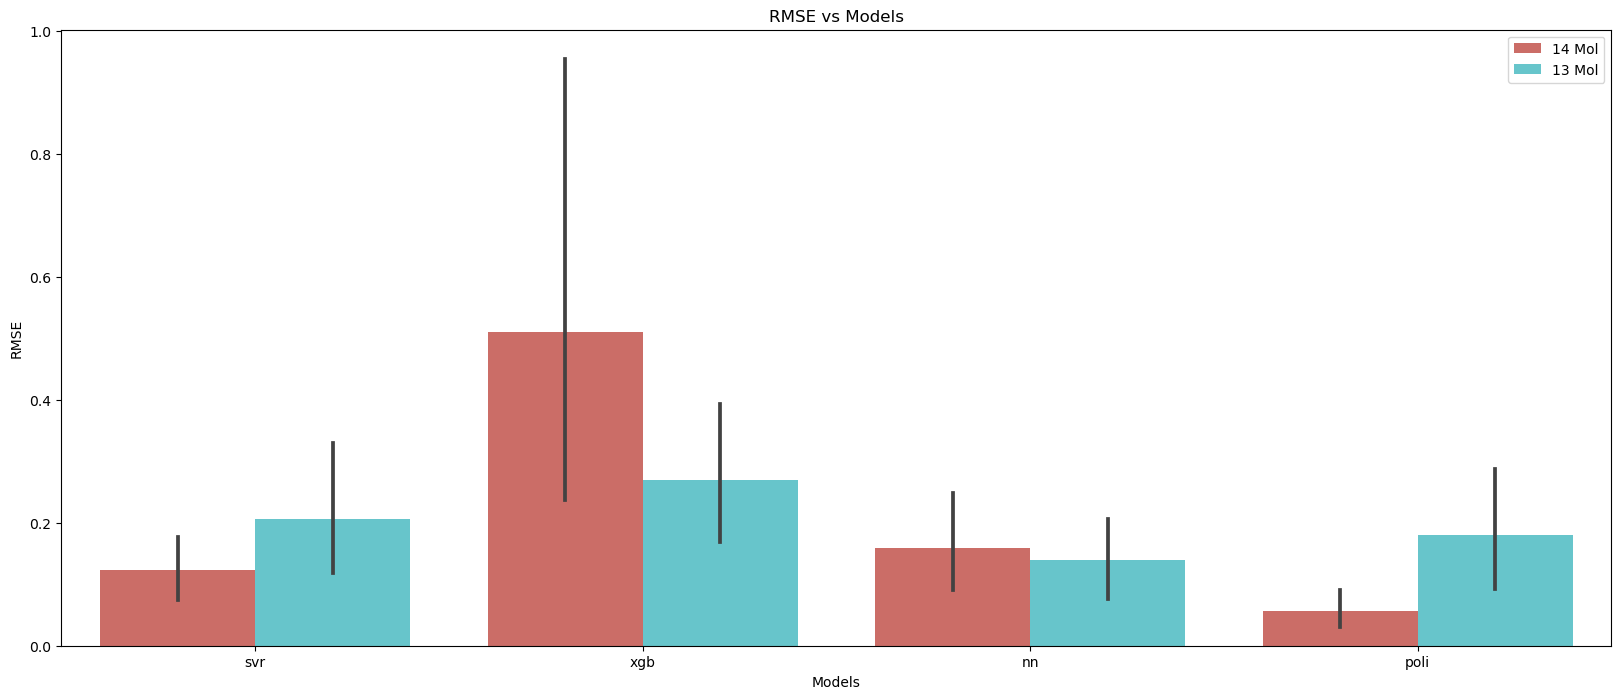

In [125]:
get_estim_dist(df_graph_nomol, aux_model=['svr','xgb','nn','poli'], hue=['14 Mol','13 Mol'])

# Feature Importance

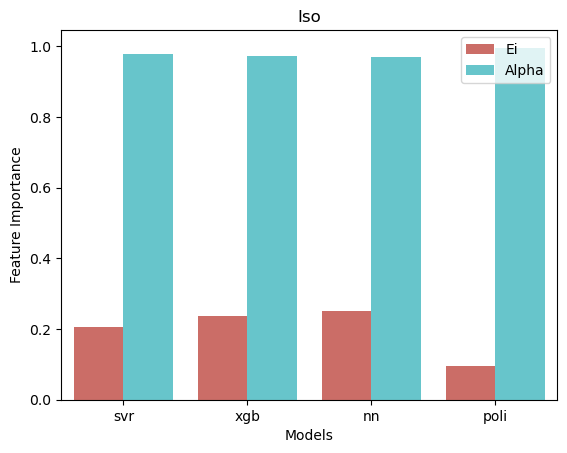

In [337]:
#Iso sem PI
feat_importance(estim_list, ['svr','xgb','nn','poli'], ['Ei', 'Alpha'], x, y, 
                len(x), n_repeats=14, title='Iso')

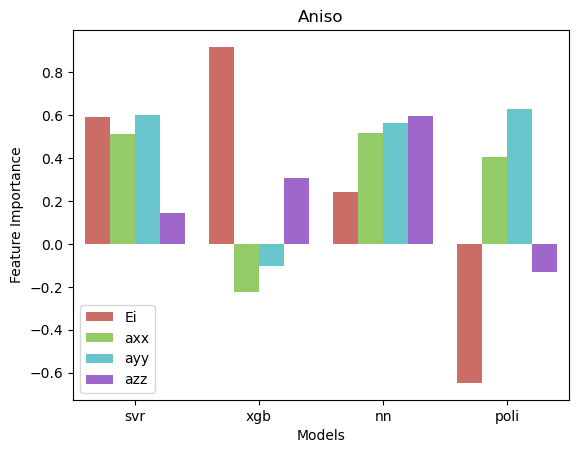

In [334]:
#Aniso sem PI
feat_importance(estim_aniso, ['svr','xgb','nn','poli'], ['Ei', 'axx','ayy','azz'], x_alpha, y, 
                len(x_alpha), n_repeats=28, title='Aniso')

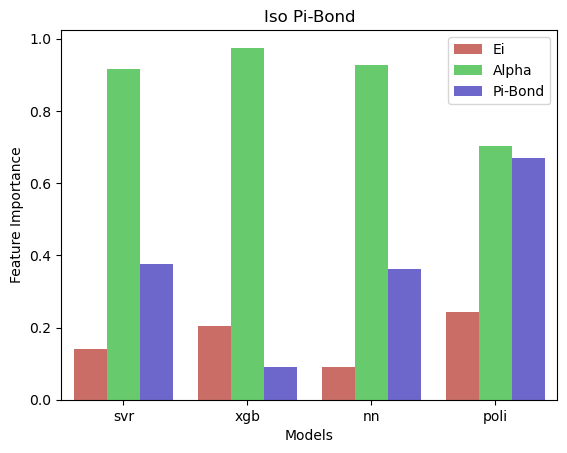

In [335]:
#Iso com PI
feat_importance(estim_list_pi, ['svr','xgb','nn','poli'], ['Ei', 'Alpha', 'Pi-Bond'], x_pi, y, 
                len(x), n_repeats=14, title='Iso Pi-Bond')

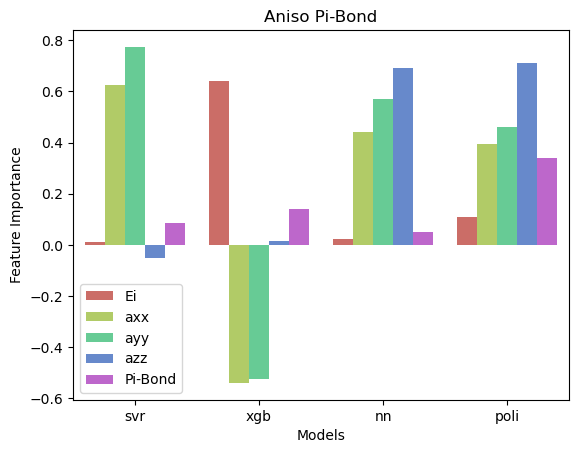

In [336]:
#Aniso com PI
feat_importance(estim_aniso_pi, ['svr','xgb','nn','poli'], ['Ei', 'axx','ayy','azz', 'Pi-Bond'], x_alpha_pi, y, 
                len(x_alpha_pi), n_repeats=14, title='Aniso Pi-Bond')